## Rescoring with Percolator and Calculating Linear and Group FDR <a target="_blank" href="https://colab.research.google.com/github/arthur-grimaud/protrein_workshopB_eubic2024/blob/main/Rescoring_FDR_estimation.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><br/>

In this analysis, we embark on rescoring PSMs with Percolator while employing a semi-supervised Support Vector Classifier (SVC) machine learning algorithm.  <br />
The ultimate goal is to enhance the confidence and accuracy of peptide-spectrum match assignments.<br />

Here's a breakdown of the process:

**1. Data Preprocessing:**

We start with a dataset of PSMs, each associated with a set of features and an Xcorr value reflecting Cross-correlation score (a measure of similarity between the observed and theoretical spectra).  <br />
Perform data preprocessing steps, including feature engineering, to ensure the dataset is appropriately formatted for the subsequent training and rescoring steps.

**2. Training the SVC Model:**

Utilizing a semi-supervised SVC machine learning algorithm, we train a model on the initial set of PSMs. <br />
The algorithm leverages both labeled and unlabeled data to capture underlying patterns that distinguish between true and false identifications. <br />
The objective is to refine the ranking and confidence estimates, providing a more accurate assessment of the likelihood of each identification. <br />

**3. Calculating Linear and Group FDR:**

Calculate the Linear False Discovery Rate (FDR) both before and after rescoring.<br />
Linear FDR is determined by assessing the proportion of false positives among all identifications, using a specified q-value threshold.<br />
Similarly, compute the Group FDR both before and after rescoring. Group FDR accounts for the fdr calculation within identified groups, offering a more refined measure of FDR.<br />

**4. Comparison and Evaluation:**

Compare the Linear and Group FDR values before and after rescoring. Evaluate the improvement in identification accuracy achieved through the efforts of semi-supervised machine learning model Percolator.<br />


In [63]:
#Uncomment the following line if packages need to install.
#!pip install psm_utils 
#!pip install mokapot==0.9.0
#!pip install scikit-learn


In [64]:
import re
import logging
import numpy as np
import pandas as pd
import mokapot
import matplotlib.pyplot as plt
from psm_utils.io import read_file

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# for reproducible results
np.random.seed(10)


In [65]:
# Helping function: Define a function to extract peptide sequence from peptidoform
# e-g QQAQVEVIRS[79.9663]GQK/2 --> QQAQVEVIRSGQK
def extract_peptide(peptidoform):
    """
    Extracts the peptide sequence from a given peptidoform.

    Parameters:
    - peptidoform (str): The input peptidoform containing sequence and modifications.

    Returns:
    - str: The extracted peptide sequence without modifications.
    """

    # Define a regular expression pattern to match alphabetical characters (A-Z, a-z)
    pattern = re.compile('[A-Za-z]+')

    # Use findall to extract all matches of the pattern from the input peptidoform
    matches = pattern.findall(peptidoform)

    # Join the matches to form the resulting peptide string
    result_peptide = ''.join(matches)

    # Return the extracted peptide sequence
    return result_peptide

# Function to check if [79.9663] is present in the peptidoform
def has_phospho(peptidoform):
    return 1 if '[79.9663]' in peptidoform else 0


In [66]:
def calcQ(df, scoreColName='Score', labelColName='Label', isPhosColName='is_phospho', addPhosQ=True, ascending=False, remove_decoy=True):
    """
    Calculate FDR and q-value for a DataFrame using the Benjamini-Hochberg procedure.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - scoreColName (str): The name of the column containing the scores.
    - labelColName (str): The name of the column containing label information (e.g., 0 or 1).
    - isPhosColName (str): The name of the column indicating phospho status.
    - addPhosQ (bool): Flag to add class-specific q-values based on phospho status.
    - ascending (bool): Whether to sort the DataFrame in ascending order based on scores.
    - remove_decoy (bool): Whether to remove the decoy from DataFrame.

    Returns:
    - df (pd.DataFrame): The input DataFrame with added columns 'FDR' and 'q-val' for FDR and q-values.
      if addPhosQ is True, then also added the 'class-specific_q-val'. 
    - Phos_df (pd.DataFrame): filter to Phospho peptides
    """

    # Check if required columns are present in the DataFrame
    if not set([scoreColName, labelColName, isPhosColName]).issubset(df.columns):
        raise Exception("Column missing")

    # Sort the DataFrame based on scores
    df.sort_values(scoreColName, ascending=ascending, inplace=True)
    
    # Replace -1 with 0 in the label column
    df[labelColName].replace(to_replace=-1, value=0, inplace=True)

    # Calculate FDR and q-value for the entire DataFrame
    df['FDR'] = (range(1, len(df) + 1) / df[labelColName].cumsum()) - 1
    df['q-val'] = df['FDR'][::-1].cummin()[::-1]

    # Add class-specific q-values if requested
    if addPhosQ:
        class_dfs = []

        for Phos in [0, 1]:
            # Filter the DataFrame based on phospho status
            currClass = pd.DataFrame(df[df[isPhosColName] == Phos])
            class_dfs.append(currClass)

            # Sort the class-specific DataFrame based on scores
            currClass.sort_values(scoreColName, ascending=ascending, inplace=True)

            # Calculate class-specific FDR and q-value
            FDR = (range(1, len(currClass[labelColName]) + 1) / currClass[labelColName].cumsum()) - 1
            currClass['class-specific_q-val'] = FDR[::-1].cummin()[::-1]

        # Concatenate class-specific DataFrames
        df = pd.concat(class_dfs)
        df.sort_values(scoreColName, ascending=ascending, inplace=True)

    # remove the decoy if requested
    if remove_decoy:
        df = df[df['Label']==1]

    # keep just phospho
    Phos_df = df[df['is_phospho'] == 1]
    
    return df, Phos_df


In [67]:
def print_FDR_summary(psm_q_df, phos_psms_q_df, q_value_thresholds=[0.01, 0.05, 0.1]):
    """
    Print a summary of True/Decoy (T/D) at different q-value thresholds.

    Parameters:
    - psm_q_df: DataFrame containing q-values for PSMs.
    - phos_psms_q_df: DataFrame containing q-values for Phosphorylated PSMs (just phospho peptides).
    - q_value_thresholds: List of q-value thresholds for summarizing results. Default is [0.01, 0.05, 0.1].
    """
    for qvalue in q_value_thresholds:
        FDR_perc = qvalue * 100
        print("T/D at " + str(FDR_perc) + "% FDR (Linear FDR): ")
        
        # Count PSMs below the q-value threshold
        psm_q_1_L = sum(j < qvalue for j in list(psm_q_df["q-val"]))
        # Count Phosphorylated PSMs below the q-value threshold
        phos_psms_q_1_L = sum(j < qvalue for j in list(phos_psms_q_df["q-val"]))
        
        print("  ==> Total PSMs at " + str(FDR_perc) + "% FDR: ", psm_q_1_L)
        print("  ==> Total Phosphorylated PSMs at " + str(FDR_perc) + "% FDR: ", phos_psms_q_1_L)

        print("T/D at " + str(FDR_perc) + "% FDR (Group (Phos) FDR): ")
        # Count Phosphorylated PSMs below the class-specific q-value threshold
        phos_psms_q_1_G = sum(j < qvalue for j in list(phos_psms_q_df["class-specific_q-val"]))
        print("  ==> Phosphorylated PSMs at " + str(FDR_perc) + "% group (phos) FDR: ", phos_psms_q_1_G)
        
        print("---------------------------------------------------\n")



In [68]:
def plot_PseudoROC(phos_psms_q_df, perc_phos_psms_q_df, q_value_col="q-val", q_value_threshold=0.01):
    """
    Plot a PseudoROC curve.

    Parameters:
    - phos_psms_q_df: DataFrame containing q-values for phospho PSMs without rescoring.
    - perc_phos_psms_q_df: DataFrame containing q-values for phospho PSMs with Percolator rescoring.
    - q_value_col: Column name containing the q-values to plot, "q-val" or "class-specific_q-val", Default is "q-val".
    - q_value_threshold: The q-value threshold for marking on the plot. Default is 0.01.
    """

    # Extract q-values and calculate cumulative counts for phospho PSMs without rescoring
    psm_score_list = list(phos_psms_q_df[q_value_col])
    list_results_psms = [] 
    q_values_psms = []
    x = -0.0002

    for i in range(10001):
        values = sum(j < x for j in psm_score_list)
        list_results_psms.append(values)
        q_values_psms.append(x)
        x = x + 0.0001

    # Extract q-values and calculate cumulative counts for phospho PSMs with Percolator rescoring
    perc_psm_score_list = list(perc_phos_psms_q_df[q_value_col])
    list_results_perc_psms = [] 
    q_values_perc_psms = []
    x = -0.0002

    for i in range(10001):
        values = sum(j < x for j in perc_psm_score_list)
        list_results_perc_psms.append(values)
        q_values_perc_psms.append(x)
        x = x + 0.0001

    # Count phospho PSMs below the specified q-value threshold for both methods
    phos_psms_count = sum(j < q_value_threshold for j in list(phos_psms_q_df[q_value_col]))
    phos_perc_psms_count = sum(j < q_value_threshold for j in list(perc_phos_psms_q_df[q_value_col]))

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(9, 7))
    ax.plot( q_values_psms, list_results_psms, label='without_rescoring', linewidth=2.0)
    ax.plot( q_values_perc_psms, list_results_perc_psms, label='percolator', linewidth=2.0)

    # Add a vertical line at the specified q-value threshold
    ax.axvline(x=q_value_threshold, color='green', linestyle='-', linewidth=1.5)

    # Set the x-axis scale to logarithmic
    ax.set_xscale('log', base=10)

    # Set plot title, labels, and legend
    if q_value_col == "q-val":
        ax.set_title("\nFDR PSM comparison of rescoring \n at " + str(q_value_threshold * 100) +
                     "% Linear FDR without_rescoring: " + str(phos_psms_count) +
                     " Percolator: " + str(phos_perc_psms_count) + " phospho PSMs", fontsize=12)
        ax.set_xlabel("q-value", fontsize=12)

    if q_value_col == "class-specific_q-val":
        ax.set_title("\nFDR PSM comparison of rescoring \n at " + str(q_value_threshold * 100) +
                     "% Group FDR without_rescoring: " + str(phos_psms_count) +
                     " Percolator: " + str(phos_perc_psms_count) + " phospho PSMs", fontsize=12)
        ax.set_xlabel("class specific (Phospho) q-value", fontsize=12)

    ax.set_ylabel("Number of Phospho PSMs", fontsize=12)
    ax.legend()
    plt.show()

#### Data preprocessing
The psm_utils used to read the pin file.

In [69]:
# pass the pin file via psm_utils read_file function
psm_list = read_file("SF_200217_pPeptideLibrary_pool1_EThcD_OT_rep1.pin")
 
# convert psm_list to dataframe
psm_df = psm_list.to_dataframe()

# show the first five rows of dataframe
psm_df.head(5)

,peptidoform,spectrum_id,run,collection,spectrum,is_decoy,score,qvalue,pep,precursor_mz,retention_time,ion_mobility,protein_list,rank,source,provenance_data,metadata,rescoring_features
0,"((I, None), (P, None), (E, None), (G, None), (...",SF_200217_pPeptideLibrary_pool1_EThcD_OT_rep1_...,None,None,None,False,None,None,None,None,None,None,"[sp|O94805|ACL6B_HUMAN, sp|O96019|ACL6A_HUMAN,...",None,percolator,{'filename': 'SF_200217_pPeptideLibrary_pool1_...,{},"{'expmass': 1316.680637, 'calcmass': 1315.6892..."
1,"((Q, None), (Q, None), (A, None), (Q, None), (...",SF_200217_pPeptideLibrary_pool1_EThcD_OT_rep1_...,None,None,None,False,None,None,None,None,None,None,[sp|Q709C8|VP13C_HUMAN],None,percolator,{'filename': 'SF_200217_pPeptideLibrary_pool1_...,{},"{'expmass': 1552.750292, 'calcmass': 1550.7686..."
2,"((D, None), (S, None), (R, None), (D, None), (...",SF_200217_pPeptideLibrary_pool1_EThcD_OT_rep1_...,None,None,None,False,None,None,None,None,None,None,[tr|A4D2M8|A4D2M8_HUMAN],None,percolator,{'filename': 'SF_200217_pPeptideLibrary_pool1_...,{},"{'expmass': 1552.74758, 'calcmass': 1551.75266..."
3,"((M, [15.9949]), (L, None), (H, None), (F, Non...",SF_200217_pPeptideLibrary_pool1_EThcD_OT_rep1_...,None,None,None,False,None,None,None,None,None,None,[sp|Q6ZQW0|I23O2_HUMAN],None,percolator,{'filename': 'SF_200217_pPeptideLibrary_pool1_...,{},"{'expmass': 1574.72893, 'calcmass': 1571.69472..."
4,"((K, None), (G, None), (T, [79.9663]), (K, Non...",SF_200217_pPeptideLibrary_pool1_EThcD_OT_rep1_...,None,None,None,False,None,None,None,None,None,None,"[sp|P48651|PTSS1_HUMAN, tr|A8KAH1|A8KAH1_HUMAN...",None,percolator,{'filename': 'SF_200217_pPeptideLibrary_pool1_...,{},"{'expmass': 1310.57329, 'calcmass': 1310.59878..."


Extract the rescoring features from rescoring_feature column which contains the dictionary

In [70]:
# extract the rescoring features from dictionary column and make a dataframe
rescoring_features = list(psm_df['rescoring_features'])
rescoring_feat_df = pd.DataFrame(rescoring_features)

# show the first five rows of dataframe
rescoring_feat_df.head(5)

,expmass,calcmass,lnrsp,deltlcn,deltcn,lnexpect,xcorr,sp,ionfrac,mass,...,charge1,charge2,charge3,charge4,enzn,enzc,enzint,lnnumsp,dm,absdm
0,1316.680637,1315.689244,0.693147,0.0,0.074288,1.615759,0.605897,6.242401,0.0682,1316.680637,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,10.526320,0.000754,0.000754
1,1552.750292,1550.768647,0.000000,0.0,0.320391,2.174828,0.360056,3.313258,0.0833,1552.750292,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,10.867730,0.001278,0.001278
2,1552.747580,1551.752663,0.000000,0.0,0.132595,-0.007583,0.842237,11.417315,0.0556,1552.747580,...,0.0,0.0,0.0,1.0,1.0,1.0,2.0,10.871080,0.000641,0.000641
3,1574.728930,1571.694725,0.000000,0.0,0.000000,3.916985,0.247798,0.956625,0.0455,1574.728930,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,10.813116,0.001931,0.001931
4,1310.573290,1310.598788,0.000000,0.0,0.080611,1.765470,0.534920,10.268522,0.1364,1310.573290,...,0.0,1.0,0.0,0.0,1.0,1.0,2.0,10.321079,-0.000019,0.000019


final_df dataframe generated for furthur rescoring.

In [71]:
# concatenate the psm_df and rescoring_df at column wise
final_df = pd.concat([psm_df, rescoring_feat_df], axis=1)

# create label from is_decoy colummn and take as integer
final_df['Label'] = (~final_df['is_decoy']).astype(int)

# provide the xcorr column is as main score column 
# (xcorr: Cross-correlation score, a measure of similarity between the observed and theoretical spectra)
final_df['score'] = final_df['xcorr']

# Apply the function to create a new column 'has_modification' filtering with phosho mod 79.9663
final_df['is_phospho'] = final_df['peptidoform'].apply(lambda x: has_phospho(str(x)))

# Apply the function to the 'peptidoform' col and create a new col 'peptide' which contain just peptide sequence 
final_df['peptide'] = final_df['peptidoform'].apply(lambda x: extract_peptide(str(x)))

# change the datatype of columns
convert_dict = {'spectrum_id': str,
                'Label': int,
                'peplen': int,
                'score': float                
               }

# apply the datatype change
final_df = final_df.astype(convert_dict)

# show the first five rows of dataframe
final_df.head(5)

,peptidoform,spectrum_id,run,collection,spectrum,is_decoy,score,qvalue,pep,precursor_mz,...,charge4,enzn,enzc,enzint,lnnumsp,dm,absdm,Label,is_phospho,peptide
0,"((I, None), (P, None), (E, None), (G, None), (...",SF_200217_pPeptideLibrary_pool1_EThcD_OT_rep1_...,None,None,None,False,0.605897,None,None,None,...,0.0,1.0,1.0,0.0,10.526320,0.000754,0.000754,1,0,IPEGLFDPSNVK
1,"((Q, None), (Q, None), (A, None), (Q, None), (...",SF_200217_pPeptideLibrary_pool1_EThcD_OT_rep1_...,None,None,None,False,0.360056,None,None,None,...,0.0,1.0,1.0,1.0,10.867730,0.001278,0.001278,1,1,QQAQVEVIRSGQK
2,"((D, None), (S, None), (R, None), (D, None), (...",SF_200217_pPeptideLibrary_pool1_EThcD_OT_rep1_...,None,None,None,False,0.842237,None,None,None,...,1.0,1.0,1.0,2.0,10.871080,0.000641,0.000641,1,1,DSRDPLVGESLKR
3,"((M, [15.9949]), (L, None), (H, None), (F, Non...",SF_200217_pPeptideLibrary_pool1_EThcD_OT_rep1_...,None,None,None,False,0.247798,None,None,None,...,0.0,1.0,1.0,0.0,10.813116,0.001931,0.001931,1,0,MLHFHYYDTSNK
4,"((K, None), (G, None), (T, [79.9663]), (K, Non...",SF_200217_pPeptideLibrary_pool1_EThcD_OT_rep1_...,None,None,None,False,0.534920,None,None,None,...,0.0,1.0,1.0,2.0,10.321079,-0.000019,0.000019,1,1,KGTKGSEDSPPK


Target and Decoy summary in final dataframe

In [72]:
print("T/D summary: \n Total number of peptides Target (1) and Decoy (0) : \n" , final_df['Label'].value_counts())
print("-------------------------------")
print("Phospho peptide T/D summary: \n Total number of phospho peptides Target (1) and Decoy (0) : \n" , final_df[final_df['is_phospho'] == 1]['Label'].value_counts())


T/D summary: 
 Total number of peptides Target (1) and Decoy (0) : 
 1    964
0    723
Name: Label, dtype: int64
-------------------------------
Phospho peptide T/D summary: 
 Total number of phospho peptides Target (1) and Decoy (0) : 
 1    653
0    431
Name: Label, dtype: int64


Put dataframe in mokapot psm format

In [73]:
# features used to train the rescoring machine learning model e-g Percolator (SVC model)
features = [ "expmass" ,"calcmass" ,"lnrsp" ,"deltlcn" ,"deltcn" ,"lnexpect" ,"xcorr" ,"sp" ,"ionfrac" ,"mass" ,"peplen" ,"charge1" ,"charge2" ,"charge3" ,"charge4" ,"enzn" ,"enzc" ,"enzint" ,"lnnumsp" , "dm" , "absdm"]


#create PSMs with mokapot interface 
psm_data = mokapot.dataset.LinearPsmDataset(
        final_df[["score", "Label", "peptide", "spectrum_id", "protein_list", "is_phospho"] + features],
        target_column="Label",
        spectrum_columns="spectrum_id",
        peptide_column="peptide", 
        group_column="is_phospho",
        feature_columns=features) 


Logging file where the rescoring logs will written

In [74]:
# Write out log file
log = True
if log:
    logging.basicConfig(
        filename="mokapot_log_file.log",
        level=logging.INFO,
        format="%(levelname)s: %(message)s",
    )


### Percolator model implementation and Training
Percolator model implementation with help of mokapot

In [75]:
# percolator model implementation with the help of Mokapot model interface
class PercolatorModel(mokapot.model.Model):
    """
    A model that emulates Percolator.
    Create linear support vector machine (SVM) model that is similar
    to the one used by Percolator. This is the default model used by
    mokapot.

    Parameters
    ----------
    scaler : scaler object or "as-is", optional
        Defines how features are normalized before model fitting and
        prediction. The default, :code:`None`, subtracts the mean and scales
        to unit variance using
        :py:class:`sklearn.preprocessing.StandardScaler`.
        Other scalers should follow the `scikit-learn transformer
        interface
        <https://scikit-learn.org/stable/developers/develop.html#apis-of-scikit-learn-objects>`_
        , implementing :code:`fit_transform()` and :code:`transform()` methods.
        Alternatively, the string :code:`"as-is"` leaves the features in
        their original scale.
    train_fdr : float, optional
        The maximum false discovery rate at which to consider a target PSM as a
        positive example.
    max_iter : int, optional
        The number of iterations to perform.
    direction : str or None, optional
        The name of the feature to use as the initial direction for ranking
        PSMs. The default, :code:`None`, automatically
        selects the feature that finds the most PSMs below the
        `train_fdr`. This
        will be ignored in the case the model is already trained.
    override : bool, optional
        If the learned model performs worse than the best feature, should
        the model still be used?
    subset_max_train : int or None, optional
        Use only a random subset of the PSMs for training. This is useful
        for very large datasets or models that scale poorly with the
        number of PSMs. The default, :code:`None` will use all of the
        PSMs.
    shuffle : bool, optional
        Should the order of PSMs be randomized for training? For deterministic
        algorithms, this will have no effect.
    n_jobs : int, optional
        The number of jobs used to parallelize the hyperparameter grid search.

        
    """

    def __init__(
        self,
        scaler=None,
        train_fdr=0.1,
        max_iter=10,
        direction=None,
        override=False,
        subset_max_train=None,
        n_jobs=-1,
    ):
        # Constants -------------------------------------------------------------------
        PERC_GRID = {
            "class_weight": [
                {0: neg, 1: pos} for neg in (0.1, 1, 10) for pos in (0.1, 1, 10)
            ]
        } 

        """Initialize a PercolatorModel"""
        self.n_jobs = n_jobs
        svm_model = LinearSVC(dual=False, random_state=7)
        estimator = GridSearchCV(
            svm_model,
            param_grid=PERC_GRID,
            refit=False,
            cv=3,
            n_jobs=n_jobs,
        )

        super().__init__(
            estimator=estimator,
            scaler=scaler,
            train_fdr=train_fdr,
            max_iter=max_iter,
            direction=direction,
            override=override,
            subset_max_train=subset_max_train,
        )


In [76]:
# make object of percolator model
perc_model = PercolatorModel()

# train the percolator model and get results
results, models = mokapot.brew(psm_data, model=perc_model, test_fdr=0.2)


### Result manipulation and plots the results

In [77]:
# merge all results into one df 
results_PSMs = pd.concat([results.group_confidence_estimates[0].psms, # peptide targets
            results.group_confidence_estimates[1].psms, # Phospho targets
            results.group_confidence_estimates[0].decoy_confidence_estimates["psms"], # peptide decoys
            results.group_confidence_estimates[1].decoy_confidence_estimates["psms"]  # Phospho decoys
            ], ignore_index=True)

# merge back column with features
mokapot_result = pd.merge(results_PSMs, final_df[['spectrum_id'] + features ], left_on='spectrum_id', right_on='spectrum_id')

# back to integer 
mokapot_result["Label"] = mokapot_result["Label"].astype(int) 

# perc score will use to calculate FDR
mokapot_result["score"] = mokapot_result["mokapot score"]

# drop the specified columns
mokapot_result.drop(columns=["mokapot q-value", "mokapot PEP"], inplace=True)


In [78]:
# calculate q-value and class-specific_q-value before rescoring 
psm_q_df, phos_psms_q_df = calcQ(final_df, scoreColName = 'score', labelColName = 'Label', isPhosColName="is_phospho", addPhosQ=True, remove_decoy=True)

# print the summary of PSMs at differnt threshold 1% and 10% Linear and Group FDR
print_FDR_summary(psm_q_df, phos_psms_q_df, q_value_thresholds=[0.01, 0.1])

T/D at 1.0% FDR (Linear FDR): 
  ==> Total PSMs at 1.0% FDR:  23
  ==> Total Phosphorylated PSMs at 1.0% FDR:  17
T/D at 1.0% FDR (Group (Phos) FDR): 
  ==> Phosphorylated PSMs at 1.0% group (phos) FDR:  23
---------------------------------------------------

T/D at 10.0% FDR (Linear FDR): 
  ==> Total PSMs at 10.0% FDR:  52
  ==> Total Phosphorylated PSMs at 10.0% FDR:  36
T/D at 10.0% FDR (Group (Phos) FDR): 
  ==> Phosphorylated PSMs at 10.0% group (phos) FDR:  34
---------------------------------------------------



In [79]:
# calculate q-value and class-specific_q-value after rescoring 
perc_psm_q_df, perc_phos_psms_q_df = calcQ(mokapot_result, scoreColName = 'score', labelColName = 'Label', isPhosColName="is_phospho", addPhosQ=True, remove_decoy=True)

# print the summary of PSMs at differnt threshold 1% and 10% Linear and Group FDR
print_FDR_summary(perc_psm_q_df, perc_phos_psms_q_df, q_value_thresholds=[0.01, 0.1])


T/D at 1.0% FDR (Linear FDR): 
  ==> Total PSMs at 1.0% FDR:  28
  ==> Total Phosphorylated PSMs at 1.0% FDR:  24
T/D at 1.0% FDR (Group (Phos) FDR): 
  ==> Phosphorylated PSMs at 1.0% group (phos) FDR:  30
---------------------------------------------------

T/D at 10.0% FDR (Linear FDR): 
  ==> Total PSMs at 10.0% FDR:  67
  ==> Total Phosphorylated PSMs at 10.0% FDR:  52
T/D at 10.0% FDR (Group (Phos) FDR): 
  ==> Phosphorylated PSMs at 10.0% group (phos) FDR:  84
---------------------------------------------------



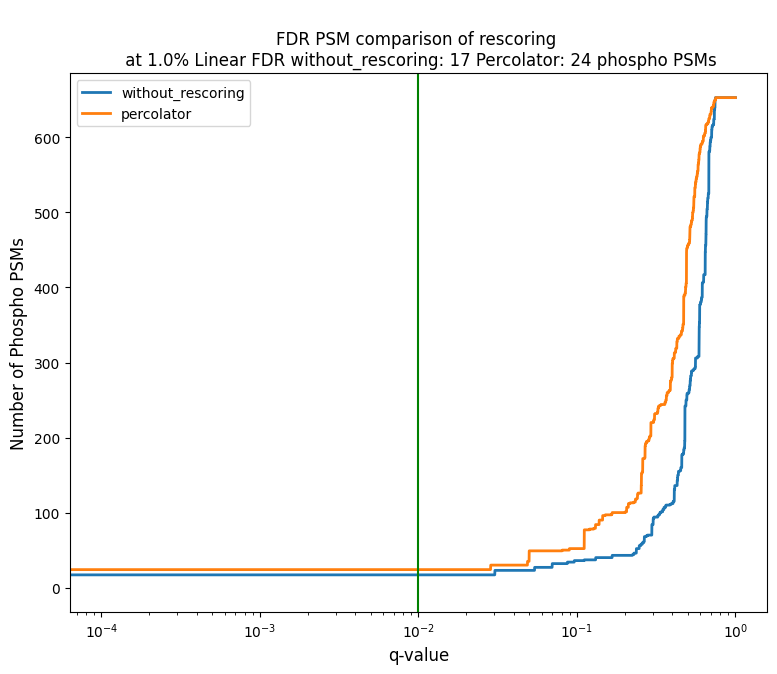

In [80]:
# Plot PseudoROC curves of Linear FDR phospho PSM comparison (after and before rescoring) with higlighted at 1% FDR 
plot_PseudoROC(phos_psms_q_df, perc_phos_psms_q_df, "q-val", q_value_threshold=0.01)

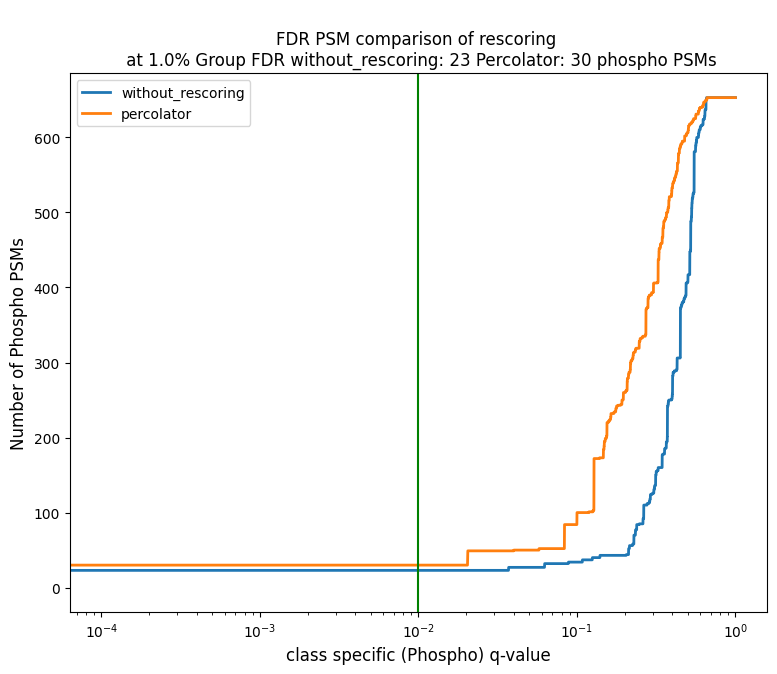

In [81]:
# Plot PseudoROC curves of Group FDR (Phospho) PSM comparison (after and before rescoring) with higlighted at 1% FDR
plot_PseudoROC(phos_psms_q_df, perc_phos_psms_q_df, "class-specific_q-val", q_value_threshold=0.01)

### Tasks:
from file "SF_200217_pPeptideLibrary_pool1_EThcD_OT_rep1.pin"
1. How many Phospho PSMs were identified at 5% Linear FDR after rescoring?
2. How many Phospho PSMs were identified at 5% Group FDR after rescoring?

Do analysis with "SF_200217_pPeptideLibrary_pool3_EThcD_OT_rep1.pin" 
1. How many Target and Decoy Phospho peptides this file contain? 
2. How many PSMs found at 5% FDR with using class-specific FDR before rescoring?
3. Which FDR gives more PSMs at 5% FDR after rescoring? How many PSMs?